In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import numpy as np

#import mpld3
#mpld3.enable_notebook()

In [68]:
#datafile = 'data/GALFA_HI_RA+DEC_140.00+18.35_W.fits'
datafile = 'data/GALFA_HI_RA+DEC_012.00+34.35_W.fits'
datacube = fits.getdata(datafile)
header = fits.getheader(datafile)

## smoothing data with a gaussian kernel

In [115]:
def GaussSM_image(image, H_beam=16.2, G_beam=4):
    ## the image is at the velocity channel of the dwarf 
    ## H_beam: HI4PI beam size in arcmin 
    ## G_beam: GALFA-HI beam size in arcmin 
    
    import numpy as np
    from scipy.ndimage import gaussian_filter
    
    pix_size = 1 # GALFA-HI pixel size, in arcmin 
    convl_beam = np.sqrt(H_beam**2 - G_beam**2) # FWHM
    sigma = convl_beam/2.355/pix_size ## kernel size in pixel, FWHM=2.355sigma
    return gaussian_filter(image, sigma=sigma)


# img[250:254, 250:254] = 100
img = datacube[1024] ## central velocity channel
sm_img = GaussSM_image(img, H_beam=8)

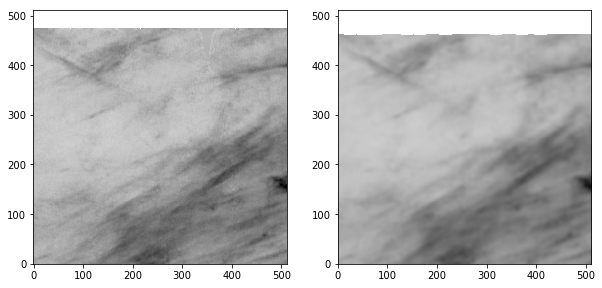

In [116]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(img, cmap=plt.cm.Greys, interpolation=None, origin='lower', vmin=-0.5, vmax=np.nanmax(img))

ax2 = fig.add_subplot(122)
ax2.imshow(sm_img, cmap=plt.cm.Greys, interpolation=None, origin='lower', vmin=-0.5, vmax=np.nanmax(img))

plt.savefig('/Users/Yong/Desktop/Smooth_GALFA_HI_RA+DEC_140.00+18.35_W.pdf')
#for ax in [ax1, ax2]:
#    ax.set_xlim(100, 300)
#    ax.set_ylim(300, 500)

In [117]:
ratio = img/sm_img

(array([  3.00000000e+00,   1.60000000e+01,   2.45000000e+02,
          4.75200000e+03,   4.98850000e+04,   1.22614000e+05,
          5.27720000e+04,   6.11600000e+03,   3.99000000e+02,
          2.90000000e+01]),
 array([ 0.80885816,  0.84335272,  0.87784729,  0.91234186,  0.94683642,
         0.98133099,  1.01582556,  1.05032012,  1.08481469,  1.11930926,
         1.15380383]),
 <a list of 10 Patch objects>)

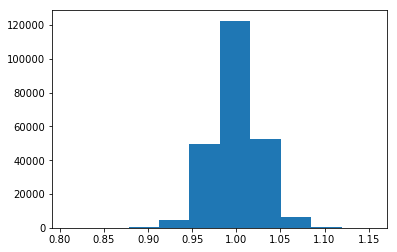

In [118]:
plt.hist(ratio[np.isfinite(ratio)].flatten())

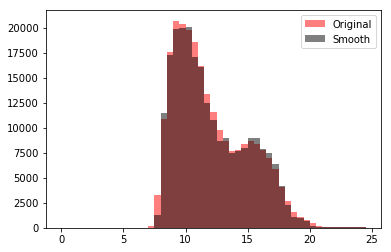

In [119]:
# double check the distribution of the original and smooth image 
a = plt.hist(img[np.isfinite(img)].flatten(), bins=np.mgrid[0:25:0.5], color='r', alpha=0.5, label='Original')
b = plt.hist(sm_img[np.isfinite(sm_img)].flatten(), bins=np.mgrid[0:25:0.5], color='k', alpha=0.5, label='Smooth')
plt.legend()

## Subtracting off the basketwave using off-v images 

In [120]:
def subtract_basketwave(datacube, tar_v, vstep):
    jump_vnum = int(np.around(20/vstep))## jump +/-20 km/s off the central vel of the source 
    
    img_v_cen = datacube[tar_v]
    img_v_left20 = datacube[tar_v-jump_vnum]
    img_v_right20 = datacube[tar_v+jump_vnum]
    
    img_mean = (img_v_left20+img_v_right20)/2.
    return img_v_cen, img_mean

In [121]:
img_cen, img_off = subtract_basketwave(datacube, 500, 0.76)

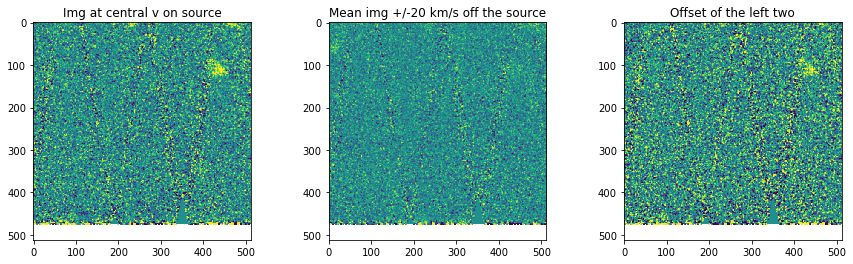

In [44]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

a = -0.5
b = 0.5
ax1.imshow(img_cen, vmin=a, vmax=b, interpolation='None')
ax2.imshow(img_off, vmin=a, vmax=b, interpolation='None')
ax3.imshow(img_cen-img_off, vmin=a, vmax=b, interpolation='None')

ax1.set_title('Img at central v on source')
ax2.set_title('Mean img +/-20 km/s off the source')
ax3.set_title('Offset of the left two')

#for ax in [ax1, ax2, ax3]:
#    ax.set_xlim(300, 500)
#    ax.set_ylim(300, 500)

## Figuring out the beam/jansky difference once smoothing the datacube

In [129]:
from astropy.modeling.models import Gaussian2D
gauss = Gaussian2D(100, 0, 0, 4/2.355, 4/2.355) # amplitude, x_mean, y_mean, x_std, y_std; 4 is GALFA beam

x = np.arange(-100, 101, 1)
y = np.arange(-100, 101, 1)
x2d, y2d = np.meshgrid(x, y)
data_2D = gauss(x2d, y2d) # + 2

sm_data_2D = GaussSM_image(data_2D, H_beam=16.2)

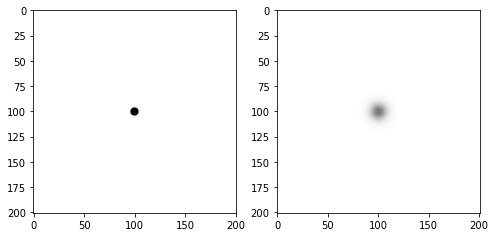

In [130]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im = ax1.imshow(data_2D, cmap=plt.cm.Greys, vmin=0, vmax=10)
ax2.imshow(sm_data_2D, cmap=plt.cm.Greys, vmin=0, vmax=10)

In [131]:
data_2D.max(), sm_data_2D.max(), data_2D.max()/sm_data_2D.max()

(100.0, 6.0970753453983342, 16.401306255051175)